In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

In [10]:
stressTests = []

patternToFind = "State:{"

for i in range(1, 11):
    with open("stress{}.log".format(i), 'r') as reader:
        lines = reader.readlines()
        empty_lines = 0
        for line in lines:
            jsonResp = line[line.index(patternToFind) + len(patternToFind) - 1:-2]
            jsonResp = jsonResp.replace(" \"", "")
            jsonResp = jsonResp.replace("\\", "")
            # print(jsonResp)
            if jsonResp == "":
                empty_lines += 1
                break
            obj = json.loads(jsonResp)
            
            stressTests.append(obj)
            print(obj)
        print("Empty lines: {}".format(empty_lines))


{'method': 'put', 'entries': 100, 'millis': 4, 'keylen': 20, 'batchapi': True, 'collection': '', 'seed': 2}
{'method': 'put', 'entries': 400, 'millis': 4, 'keylen': 20, 'batchapi': True, 'collection': '', 'seed': 3}
{'method': 'put', 'entries': 700, 'millis': 3, 'keylen': 20, 'batchapi': True, 'collection': '', 'seed': 4}
{'method': 'put', 'entries': 1000, 'millis': 3, 'keylen': 20, 'batchapi': True, 'collection': '', 'seed': 5}
{'method': 'put', 'entries': 1300, 'millis': 3, 'keylen': 20, 'batchapi': True, 'collection': '', 'seed': 6}
{'method': 'put', 'entries': 1600, 'millis': 3, 'keylen': 20, 'batchapi': True, 'collection': '', 'seed': 7}
{'method': 'put', 'entries': 1900, 'millis': 5, 'keylen': 20, 'batchapi': True, 'collection': '', 'seed': 8}
{'method': 'put', 'entries': 2200, 'millis': 7, 'keylen': 20, 'batchapi': True, 'collection': '', 'seed': 9}
{'method': 'put', 'entries': 2500, 'millis': 10, 'keylen': 20, 'batchapi': True, 'collection': '', 'seed': 10}
{'method': 'put', 'e

In [11]:
df = pd.DataFrame.from_records(stressTests)

In [12]:
df

,method,entries,millis,keylen,batchapi,collection,seed
0,put,100,4,20,True,,2
1,put,400,4,20,True,,3
2,put,700,3,20,True,,4
3,put,1000,3,20,True,,5
4,put,1300,3,20,True,,6
...,...,...,...,...,...,...,...
335,put,8800,12,20,True,,31
336,put,9100,15,20,True,,32
337,put,9400,21,20,True,,33
338,put,9700,13,20,True,,34


In [28]:
meanDf = df.groupby(['entries']).mean()

In [31]:
meanDf

,millis,keylen,batchapi,seed
entries,,,,
100,1.0,20.0,True,2.0
400,1.9,20.0,True,3.0
700,2.3,20.0,True,4.0
1000,3.0,20.0,True,5.0
1300,2.9,20.0,True,6.0
1600,3.3,20.0,True,7.0
1900,3.4,20.0,True,8.0
2200,5.0,20.0,True,9.0
2500,5.9,20.0,True,10.0


In [29]:
stdDf = df.groupby(['entries']).std()

In [35]:
stdDf

,millis,keylen,batchapi,seed
entries,,,,
100,1.154701,0.0,0.0,0.0
400,0.994429,0.0,0.0,0.0
700,0.948683,0.0,0.0,0.0
1000,1.154701,0.0,0.0,0.0
1300,0.994429,0.0,0.0,0.0
1600,1.159502,0.0,0.0,0.0
1900,1.505545,0.0,0.0,0.0
2200,1.943651,0.0,0.0,0.0
2500,2.601282,0.0,0.0,0.0


In [50]:
mean = np.array(meanDf['millis'])

In [51]:
std = np.array(stdDf['millis'])

In [59]:
entries = [name for name, _ in df.groupby(['entries'])]

In [60]:
entries

[100,
 400,
 700,
 1000,
 1300,
 1600,
 1900,
 2200,
 2500,
 2800,
 3100,
 3400,
 3700,
 4000,
 4300,
 4600,
 4900,
 5200,
 5500,
 5800,
 6100,
 6400,
 6700,
 7000,
 7300,
 7600,
 7900,
 8200,
 8500,
 8800,
 9100,
 9400,
 9700,
 10000]

<ErrorbarContainer object of 3 artists>

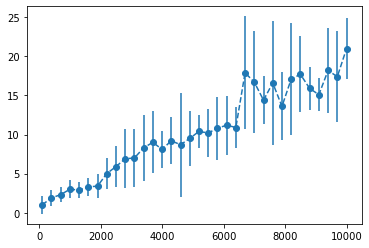

In [65]:
plt.errorbar(entries, mean, std, fmt='--o')